In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./smoking_driking_dataset_Ver01.csv')
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


In [4]:
from sklearn.preprocessing import LabelEncoder

# Encoding ordinal values

ordinal = ['sex', 'DRK_YN']

le = LabelEncoder()

df[ordinal] = df[ordinal].apply(le.fit_transform)
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1
1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0
2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0
3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0
4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0


In [5]:
# 반복된 값 제거

df = df.drop_duplicates(keep='first')

In [6]:
# Outlier removal

def remove_outliers(df, column): # used 0.1 and 0.9
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_out

def print_null_percent(df):
    null_perc = df.isna().sum() / len(df)
    return null_perc.apply(lambda x: f"{x:.1%}")

cols_to_exclude = ["sex","DRK_YN","urine_protein","hear_left","hear_right"]

for column in df.columns:
    if column not in cols_to_exclude:
        df = remove_outliers(df, column)

print_null_percent(df)

sex                 0.0%
age                 0.0%
height              0.0%
weight              0.0%
waistline           0.0%
sight_left          0.0%
sight_right         0.0%
hear_left           0.0%
hear_right          0.0%
SBP                 0.0%
DBP                 0.0%
BLDS                0.0%
tot_chole           0.0%
HDL_chole           0.0%
LDL_chole           0.0%
triglyceride        0.0%
hemoglobin          0.0%
urine_protein       0.0%
serum_creatinine    0.0%
SGOT_AST            0.0%
SGOT_ALT            0.0%
gamma_GTP           0.0%
SMK_stat_type_cd    0.0%
DRK_YN              0.0%
dtype: object

In [7]:
# Data split

target = ['SMK_stat_type_cd', 'DRK_YN']

X = df.drop(target, axis=1)
y = df['SMK_stat_type_cd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standard scaling

ss = StandardScaler()

scaled_X_train = ss.fit_transform(X_train)
scaled_X_test = ss.transform(X_test)

In [8]:
classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC(),
               LogisticRegression(),
               XGBClassifier(n_estimators=200, random_state=42)]

classifier_names = ['D_tree',
                    'RF',
                    'KNN',
                    'SVC',
                    'LR',
                    'Xgboost']

modelaccuracies = []
modelmeans = []
modelnames = []

classifier_data = zip(classifier_names, classifiers)
for classifier_names, classifiers in classifier_data:
    stf = StratifiedKFold(n_splits=10, shuffle=True)
    accuracies = cross_val_score(classifiers, X=scaled_X_train, y=y_train, cv=stf)
    print('Mean accuracy of', classifier_names, ': {:.2f} %'.format(accuracies.mean()*100))
    modelaccuracies.append(accuracies)
    modelmeans.append(accuracies.mean()*100)
    modelnames.append(classifier_names)

plt.figure(figsize=(10, 5))
plt.ylim([60, 90])
plt.bar(modelnames, modelmeans)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames)
plt.show()

Mean accuracy of D_tree : 63.05 %
Mean accuracy of RF : 69.97 %
Mean accuracy of KNN : 66.12 %
Mean accuracy of SVC : 70.14 %
Mean accuracy of LR : 69.54 %


ValueError: ignored

In [9]:
# Data split

target = ['SMK_stat_type_cd', 'DRK_YN']

X = df.drop(target, axis=1)
y_d = df['DRK_YN']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_d, test_size=0.3, random_state=0)

# Standard scaling

ss = StandardScaler()

scaled_X_train = ss.fit_transform(X_train_d)
scaled_X_test = ss.transform(X_test_d)

D_tree Mean of Metrics:
Accuracy: 0.63
Precision: 0.62
Recall: 0.62
F1 Score: 0.62

RF Mean of Metrics:
Accuracy: 0.71
Precision: 0.71
Recall: 0.70
F1 Score: 0.71

KNN Mean of Metrics:
Accuracy: 0.66
Precision: 0.65
Recall: 0.67
F1 Score: 0.66

LR Mean of Metrics:
Accuracy: 0.72
Precision: 0.72
Recall: 0.70
F1 Score: 0.71

XGB Mean of Metrics:
Accuracy: 0.70
Precision: 0.69
Recall: 0.69
F1 Score: 0.69



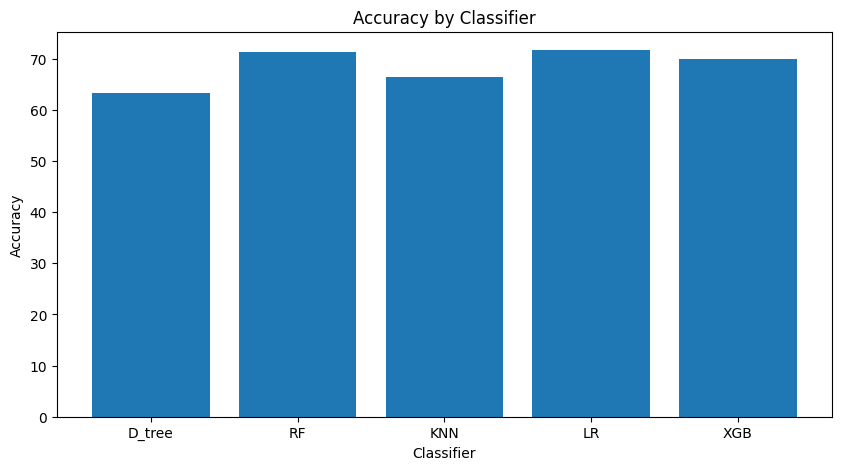

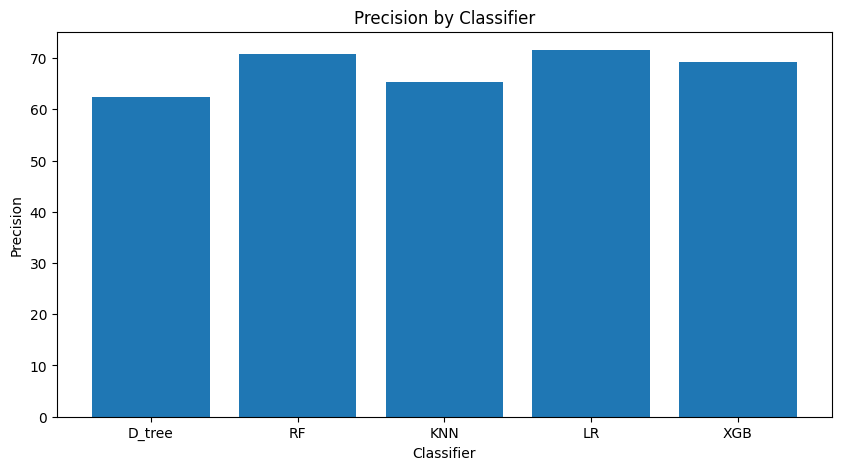

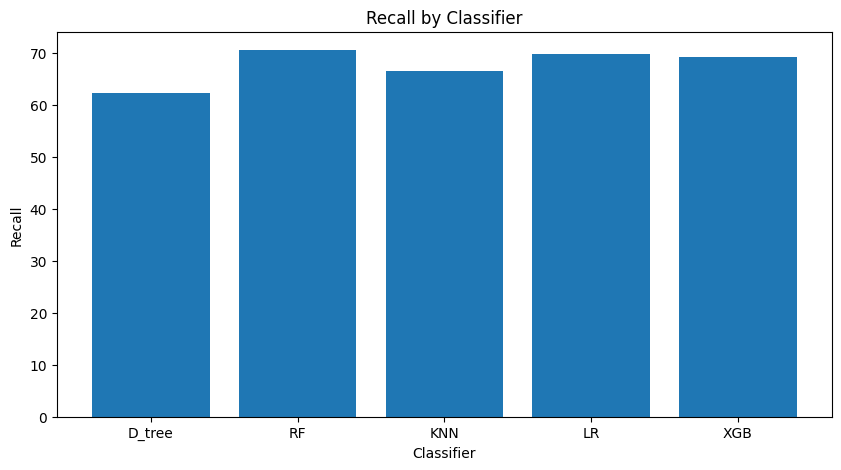

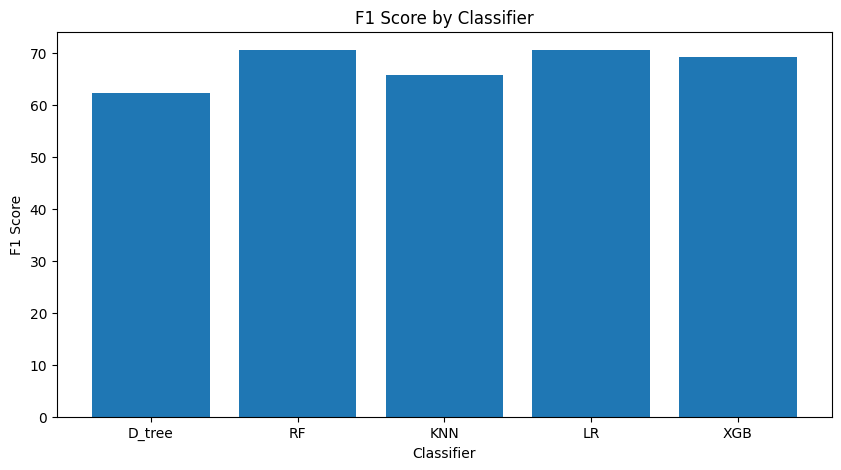

In [10]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    XGBClassifier(n_estimators=200, random_state=42),
]

classifier_names = [
    "D_tree",
    "RF",
    "KNN",
    "LR",
    "XGB",
]

model_metrics = {"Accuracy": [], "Precision": [], "Recall": [], "F1 Score": []}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
}

for classifier, classifier_name in zip(classifiers, classifier_names):
    stf = StratifiedKFold(n_splits=10, shuffle=True)
    results = cross_validate(
        classifier, X=scaled_X_train, y=y_train_d, cv=stf, scoring=scoring
    )

    accuracy_scores = results["test_accuracy"]
    precision_scores = results["test_precision"]
    recall_scores = results["test_recall"]
    f1_scores = results["test_f1_score"]

    model_metrics["Accuracy"].append(accuracy_scores)
    model_metrics["Precision"].append(precision_scores)
    model_metrics["Recall"].append(recall_scores)
    model_metrics["F1 Score"].append(f1_scores)

    print(f"{classifier_name} Mean of Metrics:")
    print(f"Accuracy: {accuracy_scores.mean():.2f}")
    print(f"Precision: {precision_scores.mean():.2f}")
    print(f"Recall: {recall_scores.mean():.2f}")
    print(f"F1 Score: {f1_scores.mean():.2f}")
    print()

# 평가 지표 시각화
metric_names = list(model_metrics.keys())

for metric_name in metric_names:
    metric_values = [np.mean(model_metrics[metric_name][i]) * 100 for i in range(len(classifiers))]

    plt.figure(figsize=(10, 5))
    plt.bar(classifier_names, metric_values)
    plt.title(f"{metric_name} by Classifier")
    plt.xlabel("Classifier")
    plt.ylabel(metric_name)

plt.show()

Mean accuracy of D_tree : 62.83 %
Mean accuracy of RF : 71.19 %
Mean accuracy of KNN : 66.35 %
Mean accuracy of SVC : 71.48 %
Mean accuracy of LR : 71.74 %
Mean accuracy of Xgboost : 69.59 %


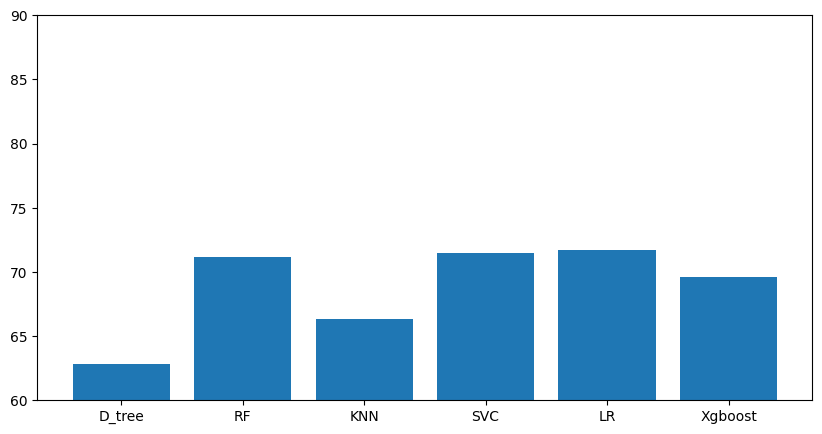

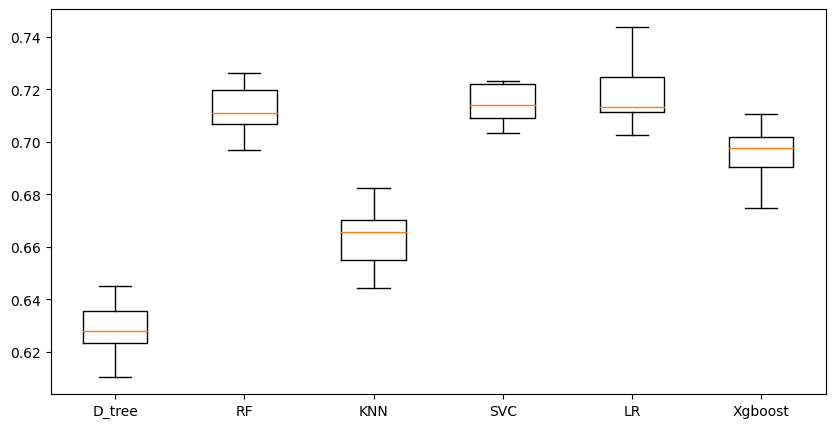

In [11]:
classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC(),
               LogisticRegression(),
               XGBClassifier(n_estimators=200, random_state=42)]

classifier_names = ['D_tree',
                    'RF',
                    'KNN',
                    'SVC',
                    'LR',
                    'Xgboost']

modelaccuracies = []
modelmeans = []
modelnames = []

classifier_data = zip(classifier_names, classifiers)
for classifier_names, classifiers in classifier_data:
    stf = StratifiedKFold(n_splits=10, shuffle=True)
    accuracies = cross_val_score(classifiers, X=scaled_X_train, y=y_train_d, cv=stf)
    print('Mean accuracy of', classifier_names, ': {:.2f} %'.format(accuracies.mean()*100))
    modelaccuracies.append(accuracies)
    modelmeans.append(accuracies.mean()*100)
    modelnames.append(classifier_names)

plt.figure(figsize=(10, 5))
plt.ylim([60, 90])
plt.bar(modelnames, modelmeans)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.boxplot(modelaccuracies)
ax.set_xticklabels(modelnames)
plt.show()

In [12]:
# Decision Tree 모델 초기화 및 학습
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(scaled_X_train, y_train_d)
dt_predictions = dt_classifier.predict(scaled_X_test)

# Random Forest 모델 초기화 및 학습
rf_classifier = RandomForestClassifier()
rf_classifier.fit(scaled_X_train, y_train_d)
rf_predictions = rf_classifier.predict(scaled_X_test)

# KNN 모델 초기화 및 학습
kn_classifier = KNeighborsClassifier()
kn_classifier.fit(scaled_X_train, y_train_d)
kn_predictions = kn_classifier.predict(scaled_X_test)

# SVC 모델 초기화 및 학습
gnb_classifier = SVC()
gnb_classifier.fit(scaled_X_train, y_train_d)
gnb_predcitions = gnb_classifier.predict(scaled_X_test)

# Logistic Regression 모델 초기화 및 학습
lr_classifier = LogisticRegression()
lr_classifier.fit(scaled_X_train, y_train_d)
lr_predictions = lr_classifier.predict(scaled_X_test)

# XGBoost 모델 초기화 및 학습
xg_classifier = XGBClassifier(n_estimators=200, random_state=42)
xg_classifier.fit(scaled_X_train, y_train_d)
xg_predictions = xg_classifier.predict(scaled_X_test)

# 각 모델의 성능 지표 계산
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# 각 모델의 성능 지표 출력
dt_accuracy, dt_precision, dt_recall, dt_f1 = calculate_metrics(y_test_d, dt_predictions)
rf_accuracy, rf_precision, rf_recall, rf_f1 = calculate_metrics(y_test_d, rf_predictions)
kn_accuracy, kn_precision, kn_recall, kn_f1 = calculate_metrics(y_test_d, kn_predictions)
gnb_accuracy, gnb_precision, gnb_recall, gnb_f1 = calculate_metrics(y_test_d, gnb_predcitions)
lr_accuracy, lr_precision, lr_recall, lr_f1 = calculate_metrics(y_test_d, lr_predictions)
xg_accuracy, xg_precision, xg_recall, xg_f1 = calculate_metrics(y_test_d, xg_predictions)

print("Decision Tree 모델 성능 지표:")
print(f"Accuracy: {dt_accuracy:.2f}")
print(f"Precision: {dt_precision:.2f}")
print(f"Recall: {dt_recall:.2f}")
print(f"F1 Score: {dt_f1:.2f}")

print("\nRandom Forest 모델 성능 지표:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"F1 Score: {rf_f1:.2f}")

print("\nKNN 모델 성능 지표:")
print(f"Accuracy: {kn_accuracy:.2f}")
print(f"Precision: {kn_precision:.2f}")
print(f"Recall: {kn_recall:.2f}")
print(f"F1 Score: {kn_f1:.2f}")

print("\nSVC 모델 성능 지표:")
print(f"Accuracy: {gnb_accuracy:.2f}")
print(f"Precision: {gnb_precision:.2f}")
print(f"Recall: {gnb_recall:.2f}")
print(f"F1 Score: {gnb_f1:.2f}")

print("\nLogistic Regression 모델 성능 지표:")
print(f"Accuracy: {lr_accuracy:.2f}")
print(f"Precision: {lr_precision:.2f}")
print(f"Recall: {lr_recall:.2f}")
print(f"F1 Score: {lr_f1:.2f}")

print("\nXGBoost 모델 성능 지표:")
print(f"Accuracy: {xg_accuracy:.2f}")
print(f"Precision: {xg_precision:.2f}")
print(f"Recall: {xg_recall:.2f}")
print(f"F1 Score: {xg_f1:.2f}")

Decision Tree 모델 성능 지표:
Accuracy: 0.63
Precision: 0.62
Recall: 0.63
F1 Score: 0.62

Random Forest 모델 성능 지표:
Accuracy: 0.72
Precision: 0.71
Recall: 0.71
F1 Score: 0.71

KNN 모델 성능 지표:
Accuracy: 0.67
Precision: 0.66
Recall: 0.68
F1 Score: 0.67

SVC 모델 성능 지표:
Accuracy: 0.73
Precision: 0.71
Recall: 0.73
F1 Score: 0.72

Logistic Regression 모델 성능 지표:
Accuracy: 0.72
Precision: 0.72
Recall: 0.71
F1 Score: 0.71

XGBoost 모델 성능 지표:
Accuracy: 0.71
Precision: 0.70
Recall: 0.71
F1 Score: 0.70
